This notebook generates SI figures for "Improving ocean carbon flux decadal prediction skill using Observationally-constrained statistical models" manuscript.

In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import nc_time_axis

import xesmf as xe
import wget
import glob
import numpy as np
import warnings
warnings.filterwarnings('ignore') # don't output warnings
import cftime
import pandas as pd
from pandas.core.nanops import nanmean as pd_nanmean
import scipy
from scipy import stats
import statsmodels.nonparametric.smoothers_lowess

Refer to Figures.ipynb for definition of the functions.

In [2]:



def area_weigh(ds, bio = None, Biome = None):
    if Biome == None:
        return (ds*(area - (ds-ds))).sum(['lat', 'lon'])/ (area - (ds-ds)).sum(['lat','lon'])
    else:
        return ((ds.where(bio == Biome))*((area - (ds-ds)).where(bio == Biome))).sum(['lat', 'lon'])/ (area - (ds-ds)).where(bio == Biome).sum(['lat','lon'])






def poli(data):
  ds = data.copy()
#   time = np.arange(1982,2021,1/12) ### run this instead if you want monthly means
  time = np.arange(1990,2020,1) ### run this instead if you want annual means
  T = ds['time']
  ds['time'] = time
  m = ds.polyfit( dim  = 'time', deg = 1).polyfit_coefficients
  
  out = m[0]*ds.time +  m[1]
  out['time'] = T
  del ds
  del T
  return m[0], out


def deseason(ds):
    clim = ds.sel(time = slice('1990','2019')).groupby('time.month').mean()
    ds2 = ds.copy()
    for i in range(0,len(ds.time),12):

        ds2[i:i+12,:,:] = clim
    return ds - ds2




def Area(ds):
    return (area - (ds-ds)).sum(['lat','lon'])


def to_pgyr(ds):
    out =  ((ds * area).sum(['lat','lon'])) * 12/1000 / 1e12
    return out 


def detrend(ds):
    try:
        out = ds - poli(ds)[1]
    except:
        out = ds - poli_mn(ds)[1]
        
    return out

def rmse(ds1,ds2):
    
    return np.sqrt(((ds1 - ds2)**2).mean())

In [3]:



def randgen_lag_corr(years):
    import random
    ls = (np.zeros(years)).astype('int')
    for i in range(years):
        if i == 0:         
            ls[i] = random.choices(np.arange(years))[0] 
        else:
            okay = True
            while okay:
                temp = random.choices(np.arange(years))[0]
                if np.abs( temp - ls[i-1])>5:
                    ls[i] = temp 
                    okay = False
    return ls 

def member_shuffle(ds, mem):
    
    return [ds[mem[:,i],i].mean('member').values.tolist() for i in range(30)]

def _confint(ds,alpha):
    
    mean = ds.median()
    max = ds.max()
    min = ds.min()
    D = xr.concat([ds for i in range(10000)], dim = 'fake')
    ranges = xr.DataArray(np.arange(10000) * np.min([max - mean, mean - min])/1000, dims = 'fake')
    ind = (D.where((D<D.median('samples') + ranges)&(D>D.median('samples') - ranges)).count('samples')/1000).values
    return (D.median('samples') - ranges)[np.argmax(ind>alpha)] ,  (D.median('samples') + ranges)[np.argmax(ind>alpha)], ind[np.argmax(ind>alpha)]


def p_value(ds):
#     return 1 - len(ds.where((ds>0)& (ds< 2*ds.median()), drop = True))/len(ds)
    return len(ds.where(ds<0, drop = True))/len(ds)



In [5]:
atm = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/atm_historical_obs_1972-2020.nc').rename({'__xarray_dataarray_variable__' : 'xCO2atm'}).xCO2atm.sel(time = slice(f'{1990}',f'{2019}'))
obs = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/Linear_regression/obs_predictors.nc').drop('mld').sel(time = slice(f'{1990}',f'{2019}'))

wind = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/wind/wind_obs_1982-2020.nc').wind.sel(time = slice(f'{1990}',f'{2019}'))

obs = xr.combine_by_coords([obs, wind, deseason(wind).to_dataset(name = 'wind_anom')])
obs['atm_anom'] = deseason(obs.atm)
obs['sst_anom'] = deseason(obs.sst)
obs['sss_anom'] = deseason(obs.sss)
obs['chl_anom'] = deseason(obs.chl)


area = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/area_obs.nc').area


In [6]:
from tqdm import tqdm
ly_dict = {}

for i in tqdm(range(1,11)):
    

    ly_dict[i] = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/1982-2020_hindcast/CanESM5_hindcast_fgco2_annual_mean_anom_1982-2020_EM_regridded.nc')[f'ly{i}'].sel(time = slice('1990','2019'))


fgco2_assim = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/CanESM5_fgco2_assim_anomaly_1990-2019_EM.nc').fgco2
fgco2_hist = xr.open_dataset('/fs/ccchome/acrnrpg/DCPP-local/CanESM5_fgco2_hist_anomaly_1990-2019_LE.nc').fgco2

100%|██████████| 10/10 [00:00<00:00, 33.88it/s]


In [8]:
sink =  xr.open_dataset('~/SeaFlux_v2021.04_fgco2_all_winds_products.nc?download=1', engine = 'netcdf4').sel(wind = 'ERA5').fgco2
sink['time'] = obs.sel(time = slice('1990','2019'))['time']

# Figure S1

Refer to Figures.ipynb for difinition of the functions.

In [9]:
def timeseries_data(name, ref_name):

    import matplotlib.transforms as transforms
    if ref_name == 'Mean':
        
        ref = sink.mean('product')
        
    else:
        ref = sink.sel(product = ref_name)   
        
    if name == 'Mean':
        recons_NN = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/Mean/Output/recons_Mean_annual_SOMFFN_sigmoid15.nc').fgco2
        recons_Lin = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/recons_MEAN_linear.nc').fgco2
    else:
        recons_NN = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/recons_{name}_annual_SOMFFN_sigmoid15.nc').fgco2
        recons_Lin = xr.open_dataset(f'/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/recons_{name}_linear.nc').fgco2
        

        
    recons_Lin = recons_Lin.resample(time = 'Y').mean()
    recons_NN = recons_NN.resample(time = 'Y').mean()
    recons_NN = recons_NN - recons_NN.mean('time')
    recons_Lin = recons_Lin - recons_Lin.mean('time')

    sink_obs = deseason(ref).resample(time = 'Y').mean()
    
    return recons_Lin, recons_NN, sink_obs
    

Plot detrended global annual mean anomalies for NN and Linear reconstructions trained on individual SeaFlux dataset as predictants.

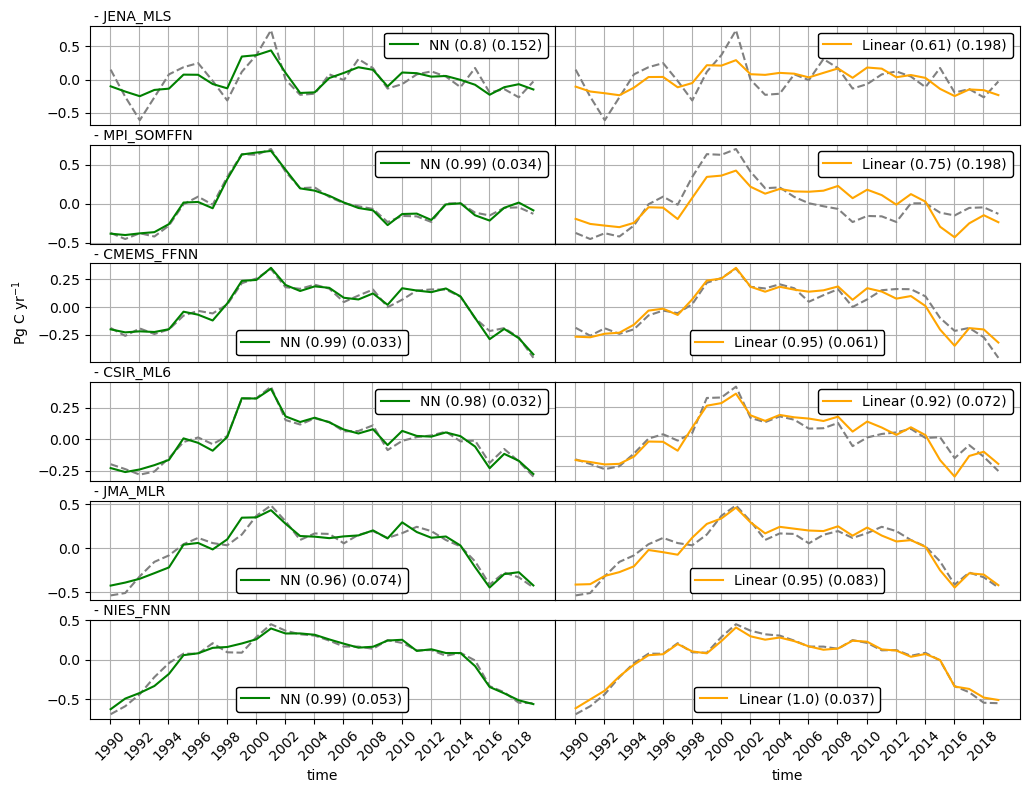

In [10]:
import matplotlib.transforms as transforms

ticks = [cftime.DatetimeNoLeap(year, 12, 16, 0, 0, 0, 0, has_year_zero=True) for year in range(1990,2020,2)]
labels = np.arange(1990,2020,2)
plt.figure( figsize = (12,9))

i = 1

for name in ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN']:

    ## Load NN and Linear reconstruction trained on individual SeaFlux products.
    recons_Lin, recons_NN, sink_obs = timeseries_data(name, name)
    ax = plt.subplot(6,2,i)

    ## Plot each SeaFlux product detrended annual mean global anomalies. 
    ds1 = detrend(to_pgyr((sink_obs)))
    ds1.plot(color = 'grey' ,linestyle = 'dashed')

    ## Plot each NN reconstruction detrended annual mean global anomalies. 
    ds = detrend(to_pgyr((recons_NN)) * Area(sink_obs)/Area(recons_NN))
    corr = xr.corr(ds, ds1, dim = 'time').values  # correaltion with reference observational product
    rsme = rmse(ds, ds1).values   # root mean square error with reference observational product
    ds.plot(color = 'green', label = f'NN ({np.round(corr,2)}) ({np.round(rsme,3)})')
    plt.title('')
    legend = plt.legend( framealpha = 1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('k')
    plt.grid('on')
    ax.text(0.01,1.05, f'- {name} ', transform=ax.transAxes)
    
    if i<11:

        ax.set_xticks(ticks)
        ax.set_xlabel('')
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)
    else:
        
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation = 45)
  
    ax = plt.subplot(6,2,i+1)

    ds1 = detrend(to_pgyr((sink_obs)))
    ds1.plot(color = 'grey',linestyle = 'dashed')

    ## Plot each Linear reconstruction detrended annual mean global anomalies. 
    ds = detrend(to_pgyr((recons_Lin)) * Area(sink_obs)/Area(recons_Lin))
    corr = xr.corr(ds, ds1, dim = 'time').values
    rsme = rmse(ds, ds1).values
    ds.plot(color = 'orange', label = f'Linear ({np.round(corr,2)}) ({np.round(rsme,3)})')
    legend = plt.legend( framealpha = 1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('k')
    plt.title('')
    plt.grid('on')
    ax.set_ylabel('')
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)

    if i<11:

        ax.set_xticks(ticks)
        ax.set_xlabel('')
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False)

    else:
        
        ax.set_xticks(ticks)
        ax.set_xticklabels(labels, rotation = 45)
    i = i+2

ax = plt.subplot(6,2,5)    
ax.set_ylabel(r'Pg C yr$^{-1}$')
    
    

ax = plt.subplot(6,2,12)
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation = 45)


plt.subplots_adjust(wspace=0, hspace=0.2)

## Figure S2

Correlation matrix of detrended global annual mean anomalies of SeaFlux products versus each other.

In [ ]:
print('SeaFlux: \n')
for ds in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
    
    correlations = {}

    for ref in  ['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean']:
        
        if ref == "Mean":
            
            if ds == 'Mean':
                    
                correlations[ref] =   np.round(xr.corr(to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean()), to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean()), 'time').values,2)
        
            else:
                                
                correlations[ref] =   np.round(xr.corr(to_pgyr(deseason(sink.sel(product = ds)).resample(time = 'Y').mean()), to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean()), 'time').values,2)

                
        else:
            
            if ds == 'Mean':
                
                correlations[ref] =   np.round(xr.corr(to_pgyr(deseason(sink.mean('product')).resample(time = 'Y').mean()), to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean()), 'time').values,2)
            else:
                
                correlations[ref] =   np.round(xr.corr(to_pgyr(deseason(sink.sel(product = ds)).resample(time = 'Y').mean()), to_pgyr(deseason(sink.sel(product = ref)).resample(time = 'Y').mean()), 'time').values,2)
        
    print( f' Trended global mean sink correlations for {ds} products are: \n {correlations}')

Creat pandas dataframe for heatmap plot.

In [15]:
import pandas as pd
  
data = {'JENA_MLS': [1.0, 0.47, 0.49, 0.63, 0.54, 0.44, 0.68],
        'MPI_SOMFFN': [np.nan, 1.0, 0.68, 0.87, 0.66, 0.61, 0.83],
        'CMEMS_FFNN': [np.nan, np.nan, 1.0,0.92, 0.9, 0.86, 0.92],
        'CSIR_ML6': [np.nan, np.nan, np.nan, 1.0,0.86, 0.8, 0.97],
        'JMA_MLR': [np.nan, np.nan, np.nan, np.nan, 1.0, 0.95, 0.94],
        'NIES_FNN': [np.nan, np.nan, np.nan, np.nan,np.nan, 1.0, 0.9],
        'Mean': [np.nan, np.nan, np.nan, np.nan, np.nan, np.nan, 1.0]}
        
  
# Creates pandas DataFrame.
df = pd.DataFrame(data, index=['JENA_MLS', 'MPI_SOMFFN', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN', 'Mean'])
  


Text(0.01, 1.05, 'a) SeaFlux detrended correlation matrix ')

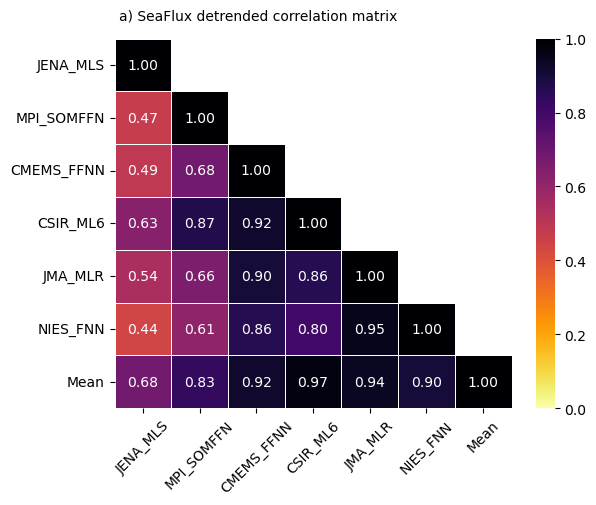

In [16]:
import seaborn as sns
ax = sns.heatmap(df, annot=True, fmt=".2f", vmin = 0, vmax = 1, cmap = 'inferno_r',linewidth=.5)
plt.xticks(rotation=45)
plt.text(0.01,1.05, 'a) SeaFlux detrended correlation matrix ', transform=ax.transAxes)


# Figure S3

Same as the manuscript figure 3 but this time using MPI-SOM-FFN as predictant and reference.

In [11]:
def skill_dict(model , ref, trend = True):

        
    if trend:
            
        obs_ts = to_pgyr((ref))
        
        if model == 'Linear':   
            
            corr_dict_mean = {}
            U_ts  = to_pgyr((Lin_hist))  * Area(ref)/Area(Lin_hist)
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in Lin_ly_dict.items():

                ds_ts = to_pgyr((ds)) * Area(ref)/Area(ds)
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
            
            A_ts  = to_pgyr((Lin_assim)) * Area(ref)/Area(Lin_assim)
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
                
        elif model == 'NN':
            
            corr_dict_mean = {}
            U_ts  = to_pgyr((NN_hist))  * Area(ref)/Area(NN_hist)
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in NN_ly_dict.items():

                ds_ts = to_pgyr((ds))* Area(ref)/Area(ds)
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = to_pgyr((NN_assim))* Area(ref)/Area(NN_assim)
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
        
        else:
            
            corr_dict_mean = {}
            U_ts  = to_pgyr((fgco2_hist.mean('member')))   * Area(ref)/Area(fgco2_hist.mean('member'))
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in ly_dict.items():

                ds_ts = to_pgyr((ds.mean('member')))* Area(ref)/Area(ds.mean('member'))
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = to_pgyr((fgco2_assim)) * Area(ref)/Area(fgco2_assim)
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)

   
        Corrected_skill_mean  = xr.DataArray(list(corr_dict_mean.values()), dims = ['lead_time']).assign_coords(lead_time = list(corr_dict_mean.keys()))


    
    else: 
        
        obs_ts = detrend(to_pgyr(ref))
        
        if model == 'Linear':   
            
            corr_dict_mean = {}
            U_ts  = detrend(to_pgyr(Lin_hist) * Area(ref)/Area(Lin_hist) )  
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in Lin_ly_dict.items():

                ds_ts = detrend(to_pgyr(ds) * Area(ref)/Area(ds) )
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = detrend(to_pgyr(Lin_assim) * Area(ref)/Area(Lin_assim)  )
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
        
        elif model =='NN':
            
            corr_dict_mean = {}
            U_ts  = detrend(to_pgyr(NN_hist) * Area(ref)/Area(NN_hist) )  
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in NN_ly_dict.items():

                ds_ts = detrend(to_pgyr(ds) * Area(ref)/Area(ds) )
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = detrend(to_pgyr(NN_assim) * Area(ref)/Area(NN_assim) )
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)

        else:
            
            corr_dict_mean = {}
            U_ts  = detrend(to_pgyr(fgco2_hist.mean('member'))  * Area(ref)/Area(fgco2_hist.mean('member')) )  
            corr_dict_mean['Historical'] = np.round(xr.corr(U_ts, obs_ts, dim = 'time').values,2)
           
            for key, ds in ly_dict.items():

                ds_ts = detrend(to_pgyr(ds.mean('member')) * Area(ref)/Area(ds.mean('member')))
                corr_dict_mean[f'{key}'] = np.round(xr.corr(ds_ts, obs_ts, dim = 'time').values,2)
                
            A_ts  = detrend(to_pgyr(fgco2_assim) * Area(ref)/Area(fgco2_assim) )
            corr_dict_mean['assim'] = np.round(xr.corr(A_ts, obs_ts, dim = 'time').values,2)
        
        Corrected_skill_mean  = xr.DataArray(list(corr_dict_mean.values()), dims = ['lead_time']).assign_coords(lead_time = list(corr_dict_mean.keys()))


    return Corrected_skill_mean





def skill_dist( ref, trend = True):

    from tqdm import tqdm
    
    if trend:
        
            obs_ts = (to_pgyr((ref)))
            
            ########################## raw CanESM5 model ######################
            I_cor = np.zeros([10,1000])
            U_cor = np.zeros([1,1000])
            bootstrap = {}

            U_ts = (to_pgyr((fgco2_hist)))

            ly_dict_ts = {}
            for key, ds in ly_dict.items():

                ly_dict_ts[key] = (to_pgyr((ds)))   

            for it in tqdm(range(1000)):

                rng = np.random.default_rng()
#                 mem = rng.choice(20, size=[20,36], replace=True)
#                 time_sample = randgen_lag_corr(36)
                mem = rng.choice(20, size=[20,30], replace=True)
                time_sample = randgen_lag_corr(30)


                O = obs_ts[time_sample]
                U_temp = U_ts[:,time_sample]
                U_temp = member_shuffle(U_temp,mem)

                U_cor[0,it] = np.corrcoef(U_temp, O.values)[0,1]

                for key, ds in ly_dict_ts.items():

                    ds = ds[:,time_sample]
                    ds = member_shuffle(ds,mem)                

                    I_cor[key-1,it] = np.corrcoef(ds, O.values)[0,1]
                bootstrap[it] = time_sample

            CanESM5_skill_dist  = xr.DataArray(np.concatenate((U_cor,I_cor)), dims = ['lead_time','samples']).assign_coords(lead_time =keys)

            ########################## NN model ######################
            
            I_cor = np.zeros([11,1000])
            U_ts = (to_pgyr((NN_hist)))
#             Assim_ts = (area_weigh((NN_assim)))

            NN_dict_ts = {}
            for key, ds in NN_ly_dict.items():

                NN_dict_ts[key] = (to_pgyr((ds)))
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              
#                 Ass_temp = Assim_ts[time_sample]

                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values
#                 I_cor[11,it] = xr.corr(Ass_temp , O_temp, dim = 'time').values

                for key, ds in NN_dict_ts.items():

                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
#             lt.append('assim')
            NN_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)
            
            ########################## Linear model ######################
            
            I_cor = np.zeros([11,1000])
            U_ts = (to_pgyr((Lin_hist)))
#             Assim_ts = (area_weigh((Lin_assim)))


            Lin_dict_ts = {}
            for key, ds in Lin_ly_dict.items():

                Lin_dict_ts[key] = (to_pgyr((ds)))
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              
#                 Ass_temp = Assim_ts[time_sample]

                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values
#                 I_cor[11,it] = xr.corr(Ass_temp , O_temp, dim = 'time').values

                for key, ds in Lin_dict_ts.items():


                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
#             lt.append('assim')
            Lin_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)
            

    else:
            
            obs_ts = detrend(to_pgyr((ref)))
            
            ########################## raw CanESM5 model ######################
            I_cor = np.zeros([10,1000])
            U_cor = np.zeros([1,1000])
            bootstrap = {}

            U_ts = detrend(to_pgyr((fgco2_hist)) * Area(ref)/Area(fgco2_hist.mean('member')) )

            ly_dict_ts = {}
            for key, ds in ly_dict.items():

                ly_dict_ts[key] = detrend(to_pgyr((ds)) * Area(ref)/Area(ds.mean('member')) )   
            
            
            for it in tqdm(range(1000)):

                rng = np.random.default_rng()
#                 mem = rng.choice(20, size=[20,36], replace=True)
#                 time_sample = randgen_lag_corr(36)
                mem = rng.choice(20, size=[20,30], replace=True)
                time_sample = randgen_lag_corr(30)

                O = obs_ts[time_sample]
                U_temp = U_ts[:,time_sample]
                U_temp = member_shuffle(U_temp,mem)

                U_cor[0,it] = np.corrcoef(U_temp, O.values)[0,1]

                for key, ds in ly_dict_ts.items():

   
                    ds = ds[:,time_sample]
                    ds = member_shuffle(ds,mem)                

                    I_cor[key-1,it] = np.corrcoef(ds, O.values)[0,1]
                bootstrap[it] = time_sample

            CanESM5_skill_dist  = xr.DataArray(np.concatenate((U_cor,I_cor)), dims = ['lead_time','samples']).assign_coords(lead_time =keys)

            ########################## NN model ######################
            
            I_cor = np.zeros([11,1000])
            U_ts = detrend(to_pgyr((NN_hist)) * Area(ref)/Area(NN_hist))
#             Assim_ts = detrend(area_weigh((NN_assim)))
            
            NN_ly_dict_ts = {}
            for key, ds in NN_ly_dict.items():

                NN_ly_dict_ts[key] = detrend(to_pgyr((ds))  * Area(ref)/Area(ds) )   
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              
#                 Ass_temp = Assim_ts[time_sample]

                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values
#                 I_cor[11,it] = xr.corr(Ass_temp , O_temp, dim = 'time').values

                for key, ds in NN_ly_dict_ts.items():

                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
#             lt.append('assim')
            NN_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)
            
            ########################## Linear model ######################
            
            I_cor = np.zeros([11,1000])
            U_ts = detrend(to_pgyr((Lin_hist)) * Area(ref)/Area(Lin_hist) )
#             Assim_ts = detrend(area_weigh((Lin_assim)))
            
            Lin_ly_dict_ts = {}
            for key, ds in Lin_ly_dict.items():

                Lin_ly_dict_ts[key] = detrend(to_pgyr((ds)) * Area(ref)/Area(ds)) 
            
            for it in tqdm(range(1000)):  

                rng = np.random.default_rng()

                time_sample = bootstrap[it]

                O_temp = obs_ts[time_sample]
                U_temp = U_ts[time_sample]
                              
#                 Ass_temp = Assim_ts[time_sample]

                I_cor[0,it] = xr.corr(U_temp , O_temp, dim = 'time').values
#                 I_cor[11,it] = xr.corr(Ass_temp , O_temp, dim = 'time').values

                for key, ds in Lin_ly_dict_ts.items():

    
                    ds = ds[time_sample]
                    I_cor[int(key),it] = xr.corr(ds, O_temp, dim = 'time').values


            lt = keys
#             lt.append('assim')
            Lin_skill_dist  = xr.DataArray(I_cor, dims = ['lead_time','samples']).assign_coords(lead_time = lt)

    return CanESM5_skill_dist, NN_skill_dist, Lin_skill_dist


keys = [f'{i}' for i in range(1,11)]
keys = ['Historical']  + keys

In [13]:


def hindcast_data(name, ref_name):
    
    if ref_name == 'Mean':
        
        ref = sink.mean('product')   
    else:
        ref = sink.sel(product = ref_name)
        
    ref = ref.resample(time = 'Y').mean() - ref.mean('time')
    
    #################################### WATCH THE TIME ######################################################

    
    NN_ly_dict = {}
    for i in range(1,11):

        NN_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/hindcast_{name}_annual_SOMFFN_sigmoid15_ly{i+1}.nc").fgco2.sel(time = slice(f'{1990}',f'{2019}')) 

    for ly in NN_ly_dict.keys():

        NN_ly_dict[ly] = (NN_ly_dict[ly].resample(time = 'Y').mean())
    #     NN_ly_dict[ly] = remove_ice(NN_ly_dict[ly])
        NN_ly_dict[ly] = NN_ly_dict[ly] - NN_ly_dict[ly].mean('time')


    #################################### WATCH THE TIME ######################################################
    Lin_ly_dict = {}
    for i in range(1,11):
        
        if name == 'Mean':

            Lin_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/hindcast_MEAN_linear_ly{i}.nc").fgco2.sel(time = slice(f'{1990}',f'{2019}')) 
         
        else:   

            Lin_ly_dict[i] = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/hindcast_{name}_linear_ly{i}.nc").fgco2.sel(time = slice(f'{1990}',f'{2019}')) 

    for ly in Lin_ly_dict.keys():


        Lin_ly_dict[ly] = (Lin_ly_dict[ly].resample(time = 'Y').mean())
    #     Lin_ly_dict[ly] = remove_ice(Lin_ly_dict[ly])
        Lin_ly_dict[ly] = Lin_ly_dict[ly] - Lin_ly_dict[ly].mean('time')


    #################################### WATCH THE TIME ######################################################

    NN_hist =  xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/hist_{name}_annual_SOMFFN_sigmoid15.nc").fgco2 
    NN_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/NN_models/SeaFlux/{name}/Output/assim_{name}_annual_SOMFFN_sigmoid15.nc").fgco2 
    
    if name == 'Mean':
        
        Lin_hist = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/hist_MEAN_linear.nc").fgco2 
        Lin_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/MEAN/assim_MEAN_annual_lienar.nc").fgco2 
        
        
    else:

        Lin_hist = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/hist_{name}_linear.nc").fgco2 
        Lin_assim = xr.open_dataset(f"/fs/ccchome/acrnrpg/DCPP-local/Paper2-final/Linear_models/SeaFlux/{name}/assim_{name}_annual_lienar.nc").fgco2 

    NN_hist = NN_hist.resample(time = 'Y').mean('time') - NN_hist.mean('time')
    NN_assim = NN_assim.resample(time = 'Y').mean('time') - NN_assim.mean('time')
    Lin_hist = Lin_hist.resample(time = 'Y').mean('time') - Lin_hist.mean('time')
    Lin_assim = Lin_assim.resample(time = 'Y').mean('time') - Lin_assim.mean('time')

    return Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref

In [13]:

NN_skills = {}
Lin_skills = {}
NN_dists = {}
Lin_dists = {}

for Name in ['JENA_MLS', 'Mean', 'CMEMS_FFNN', 'CSIR_ML6', 'JMA_MLR',  'NIES_FNN']:
    
    Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data(Name, 'MPI_SOMFFN')


    NN_skills[Name] = skill_dict('NN' , ref, trend = False)
    Lin_skills[Name] = skill_dict('Linear' , ref, trend = False)
    
NN_skills = xr.concat(list(NN_skills.values()), dim = 'product').assign_coords(product =list(NN_skills.keys()) )
Lin_skills = xr.concat(list(Lin_skills.values()), dim = 'product').assign_coords(product =list(Lin_skills.keys()) )

In [14]:
Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data('MPI_SOMFFN', 'MPI_SOMFFN')

CanESM5_skill_dist_mean, NN_skill_dist_mean, Lin_skill_dist_mean = skill_dist( ref, trend = False)
CanESM5_mean = skill_dict('CanESM5' , ref, trend = False)
NN_mean = skill_dict('NN' , ref, trend = False)
Lin_mean = skill_dict('Linear' , ref, trend = False)

100%|██████████| 1000/1000 [01:30<00:00, 11.00it/s]


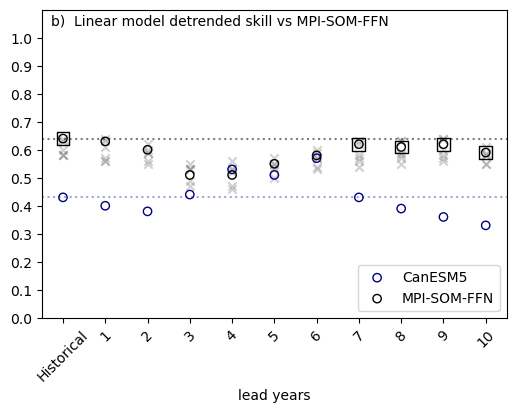

In [15]:

import matplotlib.transforms as transforms


plt.figure(figsize = (6,4))
ax = plt.subplot(1,1,1)



############## ranges ################
c = 0    
for prd in Lin_skills.product:
    
    
    Lin_skills.sel(product = prd)[:-1].plot.scatter( facecolors='grey', alpha = 0.35, marker = 'x')
    c = c +1
################## CanESM5 ###################

CanESM5_mean[:-1].plot.scatter(facecolors='none', edgecolors='navy', label = 'CanESM5')
plt.axhline(y = CanESM5_mean.sel(lead_time = 'Historical'), alpha = 0.35 , color = 'navy', linestyle = 'dotted')

################## MEAN ######################

Lin_mean[:-1].plot.scatter(facecolors='none', edgecolors='k', label = 'MPI-SOM-FFN')
plt.axhline(y = Lin_mean.sel(lead_time = 'Historical'), alpha = 0.5 , color = 'k', linestyle = 'dotted')



for ly in Lin_skill_dist_mean.lead_time.values:

    if Lin_mean.sel(lead_time = ly) > Lin_mean.sel(lead_time = 'Historical'):

        p = p_value((Lin_skill_dist_mean.sel(lead_time = ly) - Lin_skill_dist_mean.sel(lead_time = 'Historical')))
        if np.round(p,2) <= 0.05:
            plt.scatter(Lin_mean.sel(lead_time = ly).lead_time, Lin_mean.sel(lead_time = ly), facecolors='k', edgecolors='none')


for ly in Lin_mean.lead_time.values[:-1]:

    ds = CanESM5_mean.sel(lead_time = ly)
    ds_corrected = Lin_mean.sel(lead_time = ly)

    if ds_corrected > ds:
        p = p_value(Lin_skill_dist_mean.sel(lead_time = ly) - CanESM5_skill_dist_mean.sel(lead_time = ly) )

        if np.round(p,2) <= 0.05:
            plt.scatter(Lin_mean.sel(lead_time = ly).lead_time, Lin_mean.sel(lead_time = ly), facecolors='none', marker = 's', edgecolors='k', s = 85)

                                              
                      

    


plt.ylim([0.4,1.1])
plt.xlabel('lead years')

plt.text(0.02, 0.95, f'b)  Linear model detrended skill vs MPI-SOM-FFN', transform=ax.transAxes)
ticks = np.arange(0,1.05,0.1)

ax.set_yticks(ticks)
plt.xticks(rotation=45)
plt.legend(loc='lower right')     


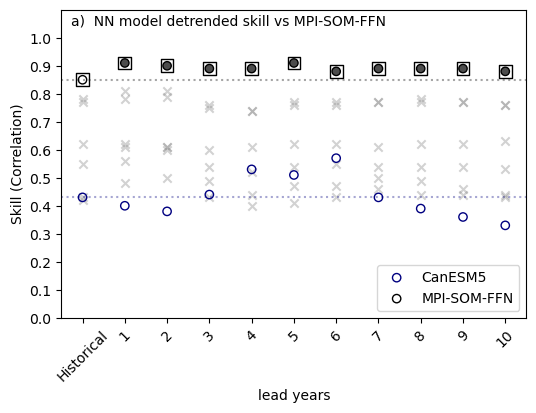

In [16]:

import matplotlib.transforms as transforms


plt.figure(figsize = (6,4))
ax = plt.subplot(1,1,1)



############## ranges ################
c = 0    
for prd in Lin_skills.product:
    
    
    NN_skills.sel(product = prd)[:-1].plot.scatter( facecolors='grey', alpha = 0.35, marker = 'x')
    c = c +1
    
################## CanESM5 ###################

CanESM5_mean[:-1].plot.scatter(facecolors='none', edgecolors='navy', label = 'CanESM5')
plt.axhline(y = CanESM5_mean.sel(lead_time = 'Historical'), alpha = 0.35 , color = 'navy', linestyle = 'dotted')
################## MEAN ######################

NN_mean[:-1].plot.scatter(facecolors='none', edgecolors='k', label = 'MPI-SOM-FFN')
plt.axhline(y = NN_mean.sel(lead_time = 'Historical'), alpha = 0.35 , color = 'k', linestyle = 'dotted')


for ly in NN_skill_dist_mean.lead_time.values:

    if NN_mean.sel(lead_time = ly) > NN_mean.sel(lead_time = 'Historical'):

        p = p_value((NN_skill_dist_mean.sel(lead_time = ly) - NN_skill_dist_mean.sel(lead_time = 'Historical')))
        if np.round(p,2) <= 0.05:
            plt.scatter(NN_mean.sel(lead_time = ly).lead_time, NN_mean.sel(lead_time = ly), facecolors='k', edgecolors='none', alpha = 0.70)


for ly in Lin_mean.lead_time.values[:-1]:

    ds = CanESM5_mean.sel(lead_time = ly)
    ds_corrected = NN_mean.sel(lead_time = ly)

    if ds_corrected > ds:
        p = p_value(NN_skill_dist_mean.sel(lead_time = ly) - CanESM5_skill_dist_mean.sel(lead_time = ly) )

        if np.round(p,2) <= 0.05:
            plt.scatter(NN_mean.sel(lead_time = ly).lead_time, NN_mean.sel(lead_time = ly), facecolors='none', marker = 's', edgecolors='k', s = 85)

                                              
                      

    


            
            
plt.ylabel('Skill (Correlation)')
plt.ylim([0,1.1])
plt.xlabel('lead years')

plt.text(0.02, 0.95, f'a)  NN model detrended skill vs MPI-SOM-FFN', transform=ax.transAxes)
ticks = np.arange(0,1.05,0.1)

ax.set_yticks(ticks)
plt.xticks(rotation=45)
plt.legend(loc='lower right')     


# Figure S4

In [14]:
Lin_ly_dict, Lin_hist, Lin_assim, NN_ly_dict, NN_hist, NN_assim, ref = hindcast_data('Mean', 'Mean')

Plot detrended global annual mean hindcast/assimilation/historical annomalies for the product trained on MEAN.

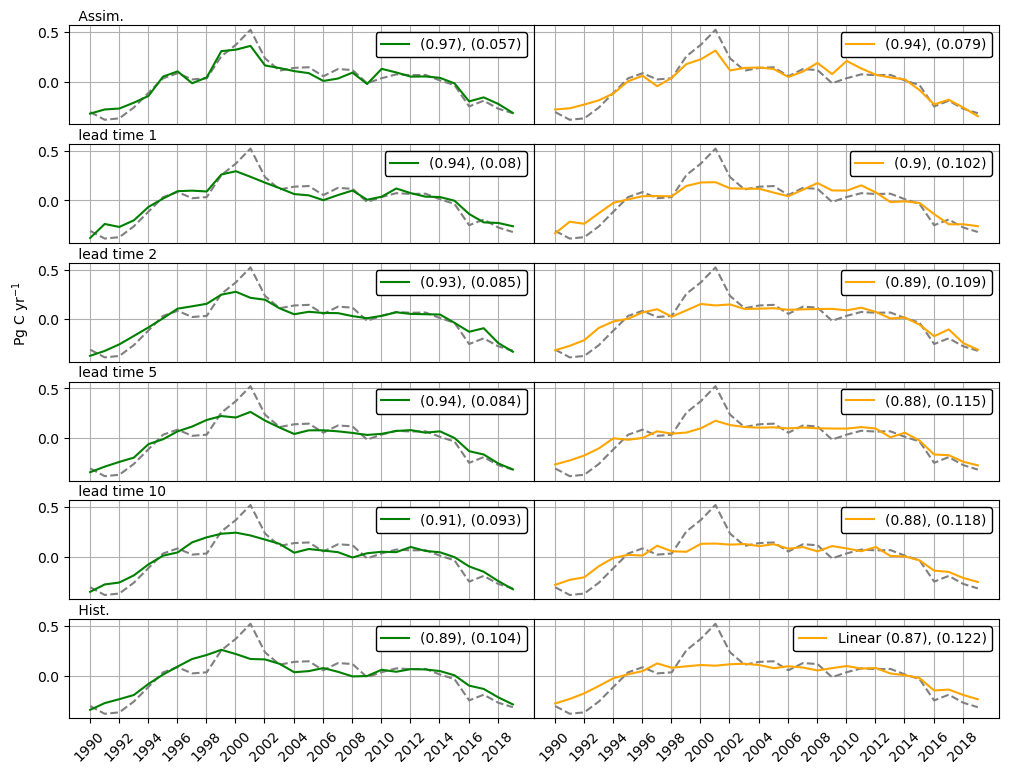

In [18]:
import matplotlib.transforms as transforms

ticks = [cftime.DatetimeNoLeap(year, 12, 16, 0, 0, 0, 0, has_year_zero=True) for year in range(1990,2020,2)]
labels = np.arange(1990,2020,2)
plt.figure( figsize = (12,9))


ax = plt.subplot(6,2,1)


################################ Assimilation ##############################

ds1 = detrend(to_pgyr((ref))) ## plot reference data
ds1.plot(color = 'grey' ,linestyle = 'dashed')

ds = detrend(to_pgyr((NN_assim))* Area(ref)/Area(NN_assim)) ## plot NN assimilation data
corr = xr.corr(ds, ds1, dim = 'time').values ## correaltioin between timeseries
rsme = rmse(ds, ds1).values ## root mean square error between timeseries
ds.plot(color = 'green', label = f'({np.round(corr,2)}), ({np.round(rsme,3)})')
plt.title('')
legend = plt.legend( framealpha = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
plt.grid('on')
ax.text(0.01,1.05, f' Assim. ', transform=ax.transAxes) 
ax.set_xticks(ticks)
ax.set_xlabel('')

## remove x ticks and labels
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)


ax = plt.subplot(6,2,2)

ds1 = detrend(to_pgyr((ref)))
ds1.plot(color = 'grey',linestyle = 'dashed')

ds = detrend(to_pgyr((Lin_assim))* Area(ref)/Area(Lin_assim)) ## plot Linear assimilation data
corr = xr.corr(ds, ds1, dim = 'time').values
rsme = rmse(ds, ds1).values
ds.plot(color = 'orange', label = f'({np.round(corr,2)}), ({np.round(rsme,3)})')
legend = plt.legend( framealpha = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
plt.title('')
plt.grid('on')
## remove y ticks and labels for the right column
ax.set_ylabel('')
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)
## remove x ticks and labels for the top rows
ax.set_xticks(ticks)
ax.set_xlabel('')
ax.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
    
    
################################ Hindcast ##############################
## iterate over your lead years of choice and plot same as above
i = 3

for ly in [1,2,5,10]:


    ax = plt.subplot(6,2,i)

    ds1 = detrend(to_pgyr((ref)))
    ds1.plot(color = 'grey' ,linestyle = 'dashed')

    ds = detrend(to_pgyr((NN_ly_dict[ly]))* Area(ref)/Area(NN_ly_dict[ly]))
    corr = xr.corr(ds, ds1, dim = 'time').values
    rsme = rmse(ds, ds1).values
    ds.plot(color = 'green', label = f'({np.round(corr,2)}), ({np.round(rsme,3)})')
    plt.title('')
    legend = plt.legend( framealpha = 1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('k')
    plt.grid('on')
    ax.text(0.01,1.05, f' lead time {ly} ', transform=ax.transAxes) 
    ax.set_xticks(ticks)
    ax.set_xlabel('')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)


    ax = plt.subplot(6,2,i+1)

    ds1 = detrend(to_pgyr((ref)))
    ds1.plot(color = 'grey',linestyle = 'dashed')

    ds = detrend(to_pgyr((Lin_ly_dict[ly])) * Area(ref)/Area(Lin_ly_dict[ly]))
    corr = xr.corr(ds, ds1, dim = 'time').values
    rsme = rmse(ds, ds1).values
    ds.plot(color = 'orange', label = f'({np.round(corr,2)}), ({np.round(rsme,3)})')
    legend = plt.legend( framealpha = 1)
    frame = legend.get_frame()
    frame.set_facecolor('white')
    frame.set_edgecolor('k')
    plt.title('')
    plt.grid('on')
    ax.set_ylabel('')
    ax.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False)
    ax.set_xticks(ticks)
    ax.set_xlabel('')
    ax.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    i = i+2

    
    

    
ax = plt.subplot(6,2,5)    
ax.set_ylabel(r'Pg C yr$^{-1}$')
    
################################ Historical ##############################

ax = plt.subplot(6,2,11)


ds1 = detrend(to_pgyr((ref)))
ds1.plot(color = 'grey' ,linestyle = 'dashed')

ds = detrend(to_pgyr((NN_hist)) * Area(ref)/Area(NN_hist))
corr = xr.corr(ds, ds1, dim = 'time').values
rsme = rmse(ds, ds1).values
ds.plot(color = 'green', label = f'({np.round(corr,2)}), ({np.round(rsme,3)})')
plt.title('')
legend = plt.legend( framealpha = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
plt.grid('on')
ax.text(0.01,1.05, f' Hist. ', transform=ax.transAxes) 

### add x ticks for the bottom subplots
ax.set_xlabel('')
ax.set_xticks(ticks)
ax.set_xticklabels(labels, rotation = 45)

ax = plt.subplot(6,2,12)

ds1 = detrend(to_pgyr((ref)))
ds1.plot(color = 'grey',linestyle = 'dashed')

ds = detrend(to_pgyr((Lin_hist))* Area(ref)/Area(Lin_hist))
rsme = rmse(ds, ds1).values
corr = xr.corr(ds, ds1, dim = 'time').values
ds.plot(color = 'orange', label = f'Linear ({np.round(corr,2)}), ({np.round(rsme,3)})')
legend = plt.legend( framealpha = 1)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('k')
plt.title('')
plt.grid('on')
ax.set_ylabel('')
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False)

### add x ticks for the bottom subplots
ax.set_xticks(ticks)
ax.set_xlabel('')
ax.set_xticklabels(labels, rotation = 45)


plt.subplots_adjust(wspace=0, hspace=0.2)